In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from collections import *
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import warnings
from scipy.misc import imrotate
import skimage.io as sio
from scipy.io import loadmat
import math
from pdb import set_trace as t
from glob import glob
from skimage import feature
from scipy import ndimage

In [2]:
# Check for SIFT and SURF. If this fails, SIFT/SURF will not run
sift = cv2.xfeatures2d.SIFT_create()
print type(sift)
print 'CV2 Loaded, Version: ' + cv2.__version__

<type 'cv2.xfeatures2d_SIFT'>
CV2 Loaded, Version: 3.2.0-dev


In [3]:
df = pd.read_csv('../data/train.csv')
image_paths = sorted(glob('../data/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

In [4]:
def run_sift(directory, filename):
    gray_img = cv2.imread(directory + filename, 0)
    color_img = cv2.imread(directory + filename)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [5]:
def sift_test(directory, filename):
    kp, desc = run_sift(directory, filename)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.imread(directory + filename, 0)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    print kp, desc

In [6]:
Hthresh = 100
nOctaves = 4
nOctaveLayers = 3
extended = False
upright = True
def run_surf(directory, filename):
    gray_img = cv2.imread(directory + filename, 0)
    color_img = cv2.imread(directory + filename)
    surf = cv2.xfeatures2d.SURF_create(Hthresh, nOctaves, nOctaveLayers, extended, upright)
    kp, desc = surf.detectAndCompute(gray_img, None)
    return kp, desc

def surf_test(directory, filename):
    kp, desc = run_surf(directory, filename)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.imread(directory + filename, 0)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    print kp, desc

[<KeyPoint 0x12adc61e0>, <KeyPoint 0x12adc62d0>] [[  16.    1.    0.    2.    3.    0.    2.   11.  117.    0.    0.    1.
     7.   17.   12.   74.   11.    0.    0.    0.  127.  102.   13.   20.
     0.    0.    0.    0.   47.   24.    0.    0.   42.    2.    2.    8.
     4.    0.    0.    4.  163.    4.    0.    1.   26.   13.    3.   55.
    38.    1.    0.    2.  163.   59.    3.   16.    0.    0.    0.    5.
    97.   12.    0.    0.   52.    5.    5.    4.    0.    0.    0.    2.
   163.   35.    1.    4.   28.    2.    0.    7.   48.   11.    1.   10.
   163.   19.    0.    1.    0.    0.    0.    2.  106.   23.    0.    0.
    45.    4.    0.    1.    0.    0.    0.    3.  163.    7.    0.    3.
    20.    0.    0.   12.   38.    2.    0.   16.  163.    1.    0.    2.
     0.    0.    0.    6.   88.    5.    0.    0.]
 [  72.    4.    0.    0.    0.    0.    0.    9.  161.    0.    0.    2.
    20.    1.    0.   44.   34.    0.    0.   35.  161.    2.    0.    8.
     0.    0

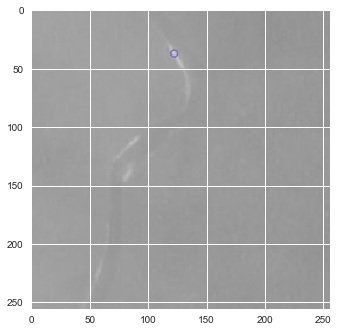

In [7]:
sift_test('../data/train-jpg/', 'train_5.jpg')

[<KeyPoint 0x12a670210>, <KeyPoint 0x12a670120>, <KeyPoint 0x12a6701b0>, <KeyPoint 0x12a6700f0>, <KeyPoint 0x12a670180>] [[  5.71073382e-04   3.20470281e-04   7.26494764e-04   4.98006062e-04
    7.33489869e-03   5.82879689e-03   1.13862939e-02   1.13172047e-02
    1.34401955e-03   1.93135459e-02   8.92301649e-03   2.01683138e-02
    1.04237336e-03   1.82721380e-03   1.68035249e-03   2.00697035e-03
   -3.20708682e-03   1.90943887e-03   5.02521684e-03   2.56582908e-02
    2.57728547e-01   2.00986713e-01   2.75827348e-01   3.49598378e-01
   -5.44787683e-02   2.22949520e-01   2.14321613e-01   3.74555409e-01
   -2.61068903e-03  -3.76135809e-03   3.53946909e-02   3.81829701e-02
    2.85398494e-03   3.26918112e-03   3.68862576e-03   4.74451203e-03
    1.89315572e-01  -2.14360908e-01   2.08312854e-01   2.64075607e-01
   -7.78364316e-02  -2.69331574e-01   1.91555515e-01   3.71608734e-01
    1.91054530e-02  -2.04813872e-02   2.78834794e-02   3.33676897e-02
    3.98759585e-04   7.47463782e-04   1

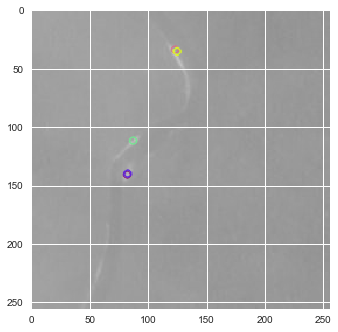

In [8]:
surf_test('../data/train-jpg/', 'train_5.jpg')

In [9]:
def sift_files(directory, count_break):
    count = 0
    sift_kp = []
    sift_desc = []
    sift_images = []
    sift_failed = []
    for filename in os.listdir(directory):
        if count == count_break:
            break
        if filename.endswith(".jpg"):
            kp, desc = run_sift(directory, filename)
            if desc is not None:
                sift_kp.append(kp)
                sift_desc.append(desc)
                sift_images.append(filename)
                count += 1
            else:
                sift_failed.append(filename)
    print len(sift_kp), len(sift_desc), len(sift_images)
    return sift_kp, sift_desc, sift_images, sift_failed

In [10]:
def surf_files(directory, count_break):
    count = 0
    surf_kp = []
    surf_desc = []
    surf_images = []
    surf_failed = []
    for filename in os.listdir(directory):
        if count == count_break:
            break
        if filename.endswith(".jpg"):
            kp, desc = run_surf(directory, filename)
            if desc is not None:
                surf_kp.append(kp)
                surf_desc.append(desc)
                surf_images.append(filename)
                count += 1
            else:
                surf_failed.append(filename)
    print len(surf_kp), len(surf_desc), len(surf_images)
    return surf_kp, surf_desc, surf_images, surf_failed

100 100 100
Failed image:  train_0.jpg
Failed image:  train_10004.jpg
Failed image:  train_10015.jpg
Failed image:  train_10019.jpg
Failed image:  train_10026.jpg
Failed image:  train_1003.jpg


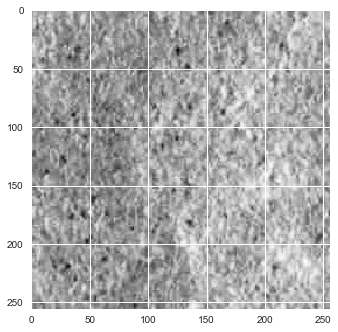

In [11]:
sift_kp, sift_desc, sift_images, sift_failed = sift_files('../data/train-jpg/', 100)
for i in range(0, 6):
    print 'Failed image: ', sift_failed[i]
    gray_img = cv2.imread('../data/train-jpg/' + sift_failed[i], 0)
    plt.imshow(gray_img)

In [12]:
surf_kp, surf_desc, surf_images, surf_failed = surf_files('../data/train-jpg/', 1000)

1000 1000 1000


In [13]:
# Code from HOG_PHOG, by Stephanie
n_samples = 500
df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]

In [20]:
# Code from HOG_PHOG
features = []
directory = '../data/train-jpg/'
for i in range(0, len(sift_images)): # For each image that gave descriptors
    filename = sift_images[i]
    raw_img = cv2.imread(directory + filename)
    raw_img = cv2.resize(raw_img, (0, 0), fx=0.5, fy=0.5)
    kp, desc = run_sift(directory, filename) 
    combined_feat = np.append(desc.reshape(1, -1), raw_img.reshape(1, -1)) # assuming desc = features
    features.append(combined_feat.reshape(1, -1))
print features
X = np.squeeze(np.array(features))
print "X shape:", X.shape

[array([[  31.,  134.,  115., ...,   83.,  100.,   95.]], dtype=float32), array([[  7.,   1.,   3., ...,  54.,  67.,  67.]], dtype=float32), array([[   4.,    2.,    0., ...,  115.,  110.,  106.]], dtype=float32), array([[ 85.,  59.,   1., ...,  87.,  85.,  71.]], dtype=float32), array([[ 24.,   2.,   0., ...,  59.,  64.,  57.]], dtype=float32), array([[ 44.,   8.,   3., ...,  55.,  56.,  45.]], dtype=float32), array([[ 80.,  23.,   4., ...,  48.,  53.,  43.]], dtype=float32), array([[  1.,   1.,   3., ...,  50.,  56.,  42.]], dtype=float32), array([[  2.,   1.,   6., ...,  56.,  61.,  45.]], dtype=float32), array([[ 10.,   6.,  37., ...,  64.,  65.,  56.]], dtype=float32), array([[ 45.,  44.,   4., ...,  49.,  62.,  55.]], dtype=float32), array([[ 10.,   9.,   1., ...,  63.,  74.,  63.]], dtype=float32), array([[  44.,  124.,   27., ...,   48.,   63.,   51.]], dtype=float32), array([[   3.,   53.,    4., ...,  128.,  153.,  152.]], dtype=float32), array([[ 13.,  19.,   8., ...,  64., 

ValueError: could not broadcast input array from shape (55936) into shape (1)

In [ ]:
# From HOG_PHOG, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# From HOG_PHOG
clf = OneVsRestClassifier(LinearSVC(penalty='l2'))
clf.fit(X_train, y_train)
score = calc_F2_score(X_test, y_test, clf)

avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

print('Average F2 test score {}'.format(avg_sample_score))
print('SVC_F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

In [ ]:
# F2 requires true positives (tp), false positives (fp), 
# and false negatives (fn)
def F2_score(tp, fp, fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    beta = 2
    F2_score = (1 + beta**2)*precision*recall/(beta**2*precision+recall)
    return F2_score